# Adaotive RAG

In [1]:
"""
STEP 3: Environment Setup
Load API credentials securely from environment variables.
"""

import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Get Google API key with error handling
GOOGLE_API_KEY = os.getenv('GOOGLE_API_KEY')
if not GOOGLE_API_KEY:
    raise ValueError("GOOGLE_API_KEY not found in environment variables")
TAVILY_API_KEY = os.getenv('TAVILY_API_KEY')
if not TAVILY_API_KEY:
    raise ValueError("TAVILY_API_KEY not found in environment variables")
LANGSMITH_API_KEY = os.getenv('LANGSMITH_API_KEY')
if not LANGSMITH_API_KEY:
    raise ValueError("LANGSMITH_API_KEY not found in environment variables")

print("✓ API keys loaded successfully")

✓ API keys loaded successfully


In [5]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings, ChatGoogleGenerativeAI

# Initialize Google embeddings model for vector representation
embedding_model = GoogleGenerativeAIEmbeddings(
    model="models/gemini-embedding-001", 
    google_api_key=GOOGLE_API_KEY
)


# Initialize Google's Gemini model for response generation
llm = ChatGoogleGenerativeAI(
    google_api_key=GOOGLE_API_KEY,
    model="gemini-2.0-flash",    # Latest fast Gemini model for quick reranking
    temperature=0,               # Deterministic output for consistency in ranking
    max_tokens=None,            # Use model default token limit
    timeout=None,               # No timeout limit for ranking requests
    max_retries=2,              # Retry failed requests twice
)

print("✓ Gemini model initialized for reranking")

✓ Gemini model initialized for reranking


E0000 00:00:1759470204.079364   16589 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.
E0000 00:00:1759470204.081546   16589 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


In [3]:
### Build Index with Rate Limiting for Gemini Free API

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
import time
import numpy as np

### from langchain_cohere import CohereEmbeddings

# Set embeddings
embd = embedding_model

# Docs to index
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

print("Loading documents...")
# Load
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]
print(f"Loaded {len(docs_list)} documents")

# Split
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)
print(f"Split into {len(doc_splits)} chunks")

# Custom function to create embeddings with rate limiting for Gemini free API
def create_vectorstore_with_rate_limit(documents, embedding_model, batch_size=3, delay=3.0):
    """
    Create FAISS vectorstore with rate limiting for Gemini free API.
    
    Args:
        documents: List of documents to embed
        embedding_model: The embedding model to use
        batch_size: Number of documents to process per batch (max 5 for free tier)
        delay: Delay in seconds between batches (minimum 2-3 seconds for free tier)
    """
    print(f"Processing {len(documents)} documents in batches of {batch_size} with {delay}s delay...")
    
    # Process first batch to initialize vectorstore
    first_batch = documents[:batch_size]
    print(f"Processing batch 1/{(len(documents) + batch_size - 1) // batch_size}: {len(first_batch)} documents")
    
    vectorstore = FAISS.from_documents(
        documents=first_batch,
        embedding=embedding_model,
    )
    
    # Process remaining documents in batches
    for i in range(batch_size, len(documents), batch_size):
        batch_num = (i // batch_size) + 1
        total_batches = (len(documents) + batch_size - 1) // batch_size
        
        # Wait before processing next batch to respect rate limits
        print(f"Waiting {delay} seconds before next batch...")
        time.sleep(delay)
        
        batch = documents[i:i + batch_size]
        print(f"Processing batch {batch_num}/{total_batches}: {len(batch)} documents")
        
        # Create temporary vectorstore for this batch
        temp_vectorstore = FAISS.from_documents(
            documents=batch,
            embedding=embedding_model,
        )
        
        # Merge with main vectorstore
        vectorstore.merge_from(temp_vectorstore)
    
    print("✓ Vectorstore creation completed!")
    return vectorstore

# Create vectorstore with rate limiting
vectorstore = create_vectorstore_with_rate_limit(
    documents=doc_splits,
    embedding_model=embd,
    batch_size=3,  # Conservative batch size for free tier
    delay=3.0      # 3 second delay between batches
)

retriever = vectorstore.as_retriever()
print("✓ Retriever initialized successfully")

USER_AGENT environment variable not set, consider setting it to identify your requests.


Loading documents...
Loaded 3 documents
Split into 88 chunks
Processing 88 documents in batches of 3 with 3.0s delay...
Processing batch 1/30: 3 documents
Waiting 3.0 seconds before next batch...
Processing batch 2/30: 3 documents
Waiting 3.0 seconds before next batch...
Processing batch 3/30: 3 documents
Waiting 3.0 seconds before next batch...
Processing batch 4/30: 3 documents
Waiting 3.0 seconds before next batch...
Processing batch 5/30: 3 documents
Waiting 3.0 seconds before next batch...
Processing batch 6/30: 3 documents
Waiting 3.0 seconds before next batch...
Processing batch 7/30: 3 documents
Waiting 3.0 seconds before next batch...
Processing batch 8/30: 3 documents
Waiting 3.0 seconds before next batch...
Processing batch 9/30: 3 documents
Waiting 3.0 seconds before next batch...
Processing batch 10/30: 3 documents
Waiting 3.0 seconds before next batch...
Processing batch 11/30: 3 documents
Waiting 3.0 seconds before next batch...
Processing batch 12/30: 3 documents
Waitin

In [6]:
### Router

from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

from pydantic import BaseModel, Field

# Data model
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["vectorstore", "web_search"] = Field(
        ...,
        description="Given a user question choose to route it to web search or a vectorstore.",
    )

# LLM with function call

structured_llm_router = llm.with_structured_output(RouteQuery)

# Prompt
system = """You are an expert at routing a user question to a vectorstore or web search.
The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
Use the vectorstore for questions on these topics. Otherwise, use web-search."""
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

question_router = route_prompt | structured_llm_router

print(
    question_router.invoke(
        {"question": "Who won the Cricket world cup 2023 "}
    )
)


datasource='web_search'


In [7]:
print(question_router.invoke({"question": "What are the types of agent memory?"}))

datasource='vectorstore'


In [8]:
### Retrieval Grader


# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader
question = "agent memory"
## context
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='yes'


In [9]:
### Generate

from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull("rlm/rag-prompt")


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

Agent memory includes short-term and long-term memory. Short-term memory refers to in-context learning, while long-term memory provides the capability to retain and recall information over extended periods using an external vector store. Sensory memory is also present, learning embedding representations for raw inputs like text or images.


In [23]:
prompt.messages[0].prompt.template

"You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"

In [24]:
print(prompt.messages[0].prompt.template)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


In [10]:
### Hallucination Grader


# Data model
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )


# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

# Prompt
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n 
     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_grader
hallucination_grader.invoke({"documents": docs, "generation": generation})

GradeHallucinations(binary_score='yes')

In [28]:
### Answer Grader


# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeAnswer)

# Prompt
system = """You are a grader assessing whether an answer addresses / resolves a question \n 
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader
answer_grader.invoke({"question": question, "generation": generation})

GradeAnswer(binary_score='yes')

In [29]:
### Question Re-writer

# Prompt
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

'What are the key concepts and techniques related to agent memory in artificial intelligence?'

In [30]:
### Search

from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

In [31]:
from typing import List

from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]

In [32]:
from langchain.schema import Document


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question}


def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}


def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)

    return {"documents": web_results, "question": question}


### Edges ###


def route_question(state):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "web_search":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "web_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

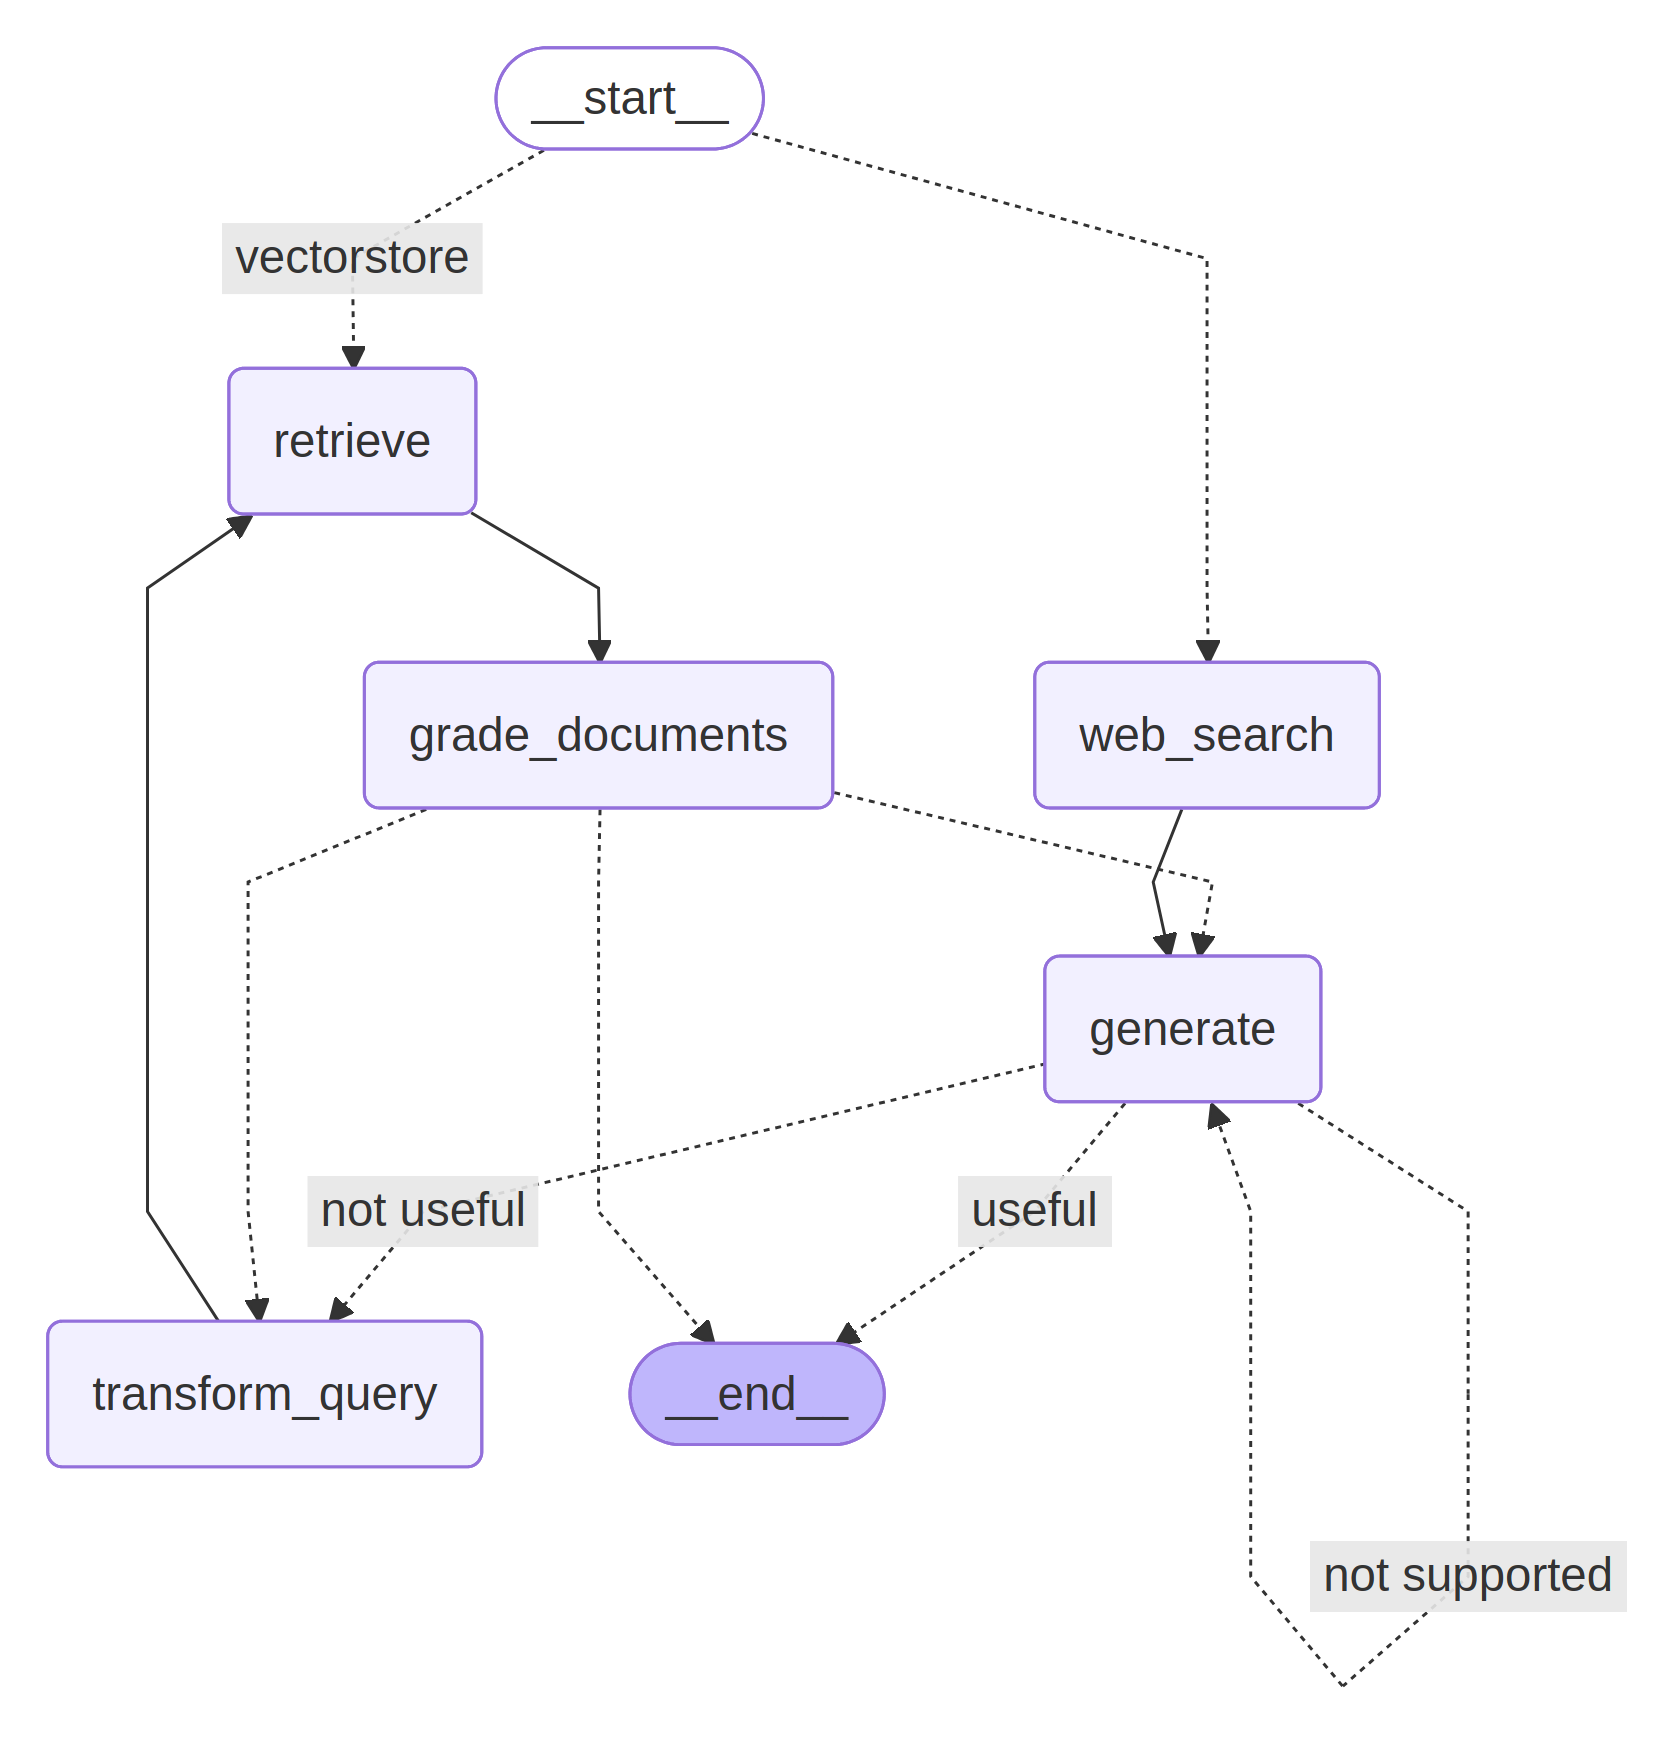

In [33]:
from langgraph.graph import END, StateGraph, START

from langchain_core.runnables.graph import MermaidDrawMethod 

import nest_asyncio
nest_asyncio.apply()

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("web_search", web_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generate
workflow.add_node("transform_query", transform_query)  # transform_query

# Build graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "web_search": "web_search",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)

# Compile
app = workflow.compile()

# Visualize the workflow graph
from IPython.display import Image, display
display(Image(app.get_graph(xray=True).draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)))

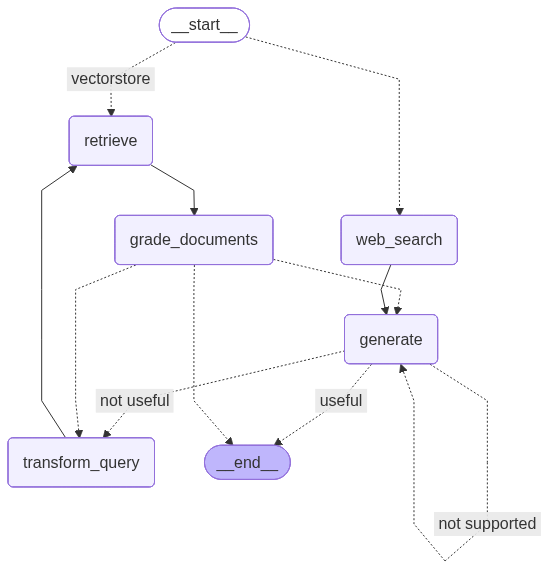

In [36]:
app

In [34]:
app.invoke({"question":"What is machine learning"})

---ROUTE QUESTION---
---ROUTE QUESTION TO WEB SEARCH---
---WEB SEARCH---
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---


{'question': 'What is machine learning',
 'generation': 'Machine learning is a subset of artificial intelligence focused on algorithms that learn patterns from training data. These algorithms create models capable of performing tasks that typically require human intelligence. The models can make accurate inferences and predictions about new data.',
 'documents': Document(metadata={}, page_content='Machine learning is the subset of artificial intelligence (AI) focused on algorithms that can “learn” the patterns of training data and, subsequently, make accurate\xa0*inferences*\xa0about new data. The central premise of machine learning (ML) is that if you optimize a model’s performance on a dataset of tasks that adequately resemble the real-world problems it will be used for—through a process called\xa0model training—the model can make accurate predictions on the\xa0new\xa0data it sees in its ultimate use case. In essence, a trained model is applying patterns it learned from training data

In [35]:
app.invoke({"question":"Who won the ODI Cricket worldcup in 2023?"})

---ROUTE QUESTION---
---ROUTE QUESTION TO WEB SEARCH---
---WEB SEARCH---
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---


{'question': 'Who won the ODI Cricket worldcup in 2023?',
 'generation': 'Australia won the ODI Cricket World Cup in 2023. They defeated India in the final match played on November 19, 2023, at the Narendra Modi Stadium in Ahmedabad. Australia won the final by six wickets.',
 'documents': Document(metadata={}, page_content="In the knockout stage, India and Australia beat New Zealand and South Africa, respectively, to advance to the final, played on 19 November at the Narendra Modi\n| **Fall of wickets:** **1-30** (Shubman Gill, 4.2 ov), **2-76** (Rohit Sharma, 9.4 ov), **3-81** (Shreyas Iyer, 10.2 ov), **4-148** (Virat Kohli, 28.3 ov), **5-178** (Ravindra Jadeja, 35.5 ov), **6-203** (KL Rahul, 41.3 ov), **7-211** (Mohammed Shami, 43.4 ov), **8-214** (Jasprit Bumrah, 44.5 ov), **9-226** (Suryakumar Yadav, 47.3 ov), **10-240** (Kuldeep Yadav, 49.6 ov)\xa0•\xa0DRS | | | | | | | | | * 4th Wicket: 50 runs in 70 balls (TM Head 32, M Labuschagne 12, Ex 6) * 4th Wicket: 100 runs in 119 balls (